In [185]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Data Loaders
CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size. source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [239]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# parameters
batch_size = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [99]:
trainset, testset

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

In [100]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Data Viz
Since we are trying to classify into 10 classes. We should:
1. Display sample images
2. Figure out quantity of each classs. Do we have equal distribution of each class?
3. Find interesting features of the data. For example, deers can be on the brown-gray spectrum while automobiles comes in any color. This can be done later on as feature engineering to improve the end result. Can do a first attempt without these added features

#### display a few examples

In [170]:
def img_transform(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

In [250]:
def show_images(images, labels, predicted_labels=None, n_cols=8, n_rows=3, random_sample=True, batch_size=10):
    # show images
    # n_cols = 8
    # n_rows = 3
    n_samples_images = n_cols * n_rows
    axes = []
    fig = plt.figure(figsize=[12, 8])

    if random_sample:
        sample_idx = np.random.randint(batch_size, size=(n_samples_images)) # randomly sample rows*cols images from the batch
    else:
        sample_idx = np.array([i+1 for i in range(n_cols*n_rows)]) # samples in order 1,2,3 ...

    for i in range(n_rows * n_cols):
        sample_image = img_transform((images[sample_idx[i]])) # unnormalize and transpose to use with plt.imshow
        axes.append(fig.add_subplot(n_rows, n_cols, i+1))
        
        actual_label = (classes[labels[sample_idx[i]]])
        
        if predicted_labels is not None:
            predicted_label = classes[predicted_labels[sample_idx[i]]]
            axes[-1].set_title("predicted: " + str(predicted_label) + " actual: " + actual_label)  
        else:
            axes[-1].set_title(actual_label)  
            
        plt.imshow(sample_image)
    fig.tight_layout()    
    plt.show()

In [168]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#### checking that each class is equally distributed

In [156]:
all_train_data = torch.utils.data.DataLoader(trainset, len(trainset), shuffle=True, num_workers=2)

In [157]:
dataiter = iter(all_train_data)
all_images, all_labels = dataiter.next()

(array([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <BarContainer object of 10 artists>)

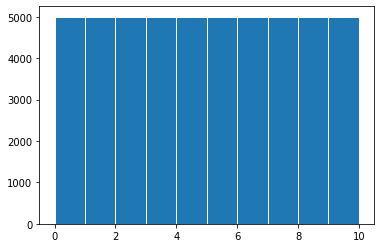

In [166]:
plt.hist(all_labels.numpy(), bins=[0,1,2,3,4,5,6,7,8,9, 10], edgecolor='white')

### Model Construction
We can try a few combinations of models and hyper parameters

In [177]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [241]:
num_epochs = 3
learning_rate = 0.001
momentum = 0.9
criterion = nn.CrossEntropyLoss()
model = ConvNet()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [269]:
def train_model(trainloader, model, num_epochs, save_model=True):
    n_total_steps = len(trainloader)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i+1) % 1000 == 0:    
                print(f'[epoch {epoch+1} / {num_epochs}, step:{i+1}/{n_total_steps} loss: {loss.item()}')
                running_loss = 0.0

    print('Finished Training')
    if save_model:
        PATH = './cifar_cnn.pth'
        torch.save(model.state_dict(), PATH)
    return model

In [243]:
dataiter = iter(testloader)
test_images, test_labels = dataiter.next()

In [256]:
def test_model(testloader, model, batch_size):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) # use max because outputs are energies
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')

        for i in range(10):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {acc} %')
    return acc

In [245]:
energies = model(test_images)
_, predicted_labels = torch.max(energies, 1)

In [246]:
test_labels, predicted_labels

(tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
         5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
         7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
         8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
         6, 0, 0, 7]),
 tensor([5, 8, 8, 8, 5, 1, 5, 6, 8, 8, 0, 8, 6, 1, 1, 9, 5, 7, 8, 6, 9, 7, 7, 7,
         0, 9, 6, 9, 9, 6, 6, 7, 5, 6, 9, 6, 7, 8, 9, 5, 9, 6, 7, 6, 8, 8, 5, 1,
         6, 6, 9, 9, 6, 1, 8, 8, 5, 1, 8, 7, 5, 5, 6, 9, 6, 6, 8, 0, 6, 9, 0, 6,
         8, 8, 9, 7, 9, 1, 6, 8, 0, 1, 6, 0, 0, 9, 9, 8, 8, 8, 8, 7, 8, 9, 9, 5,
         6, 0, 7, 9]))

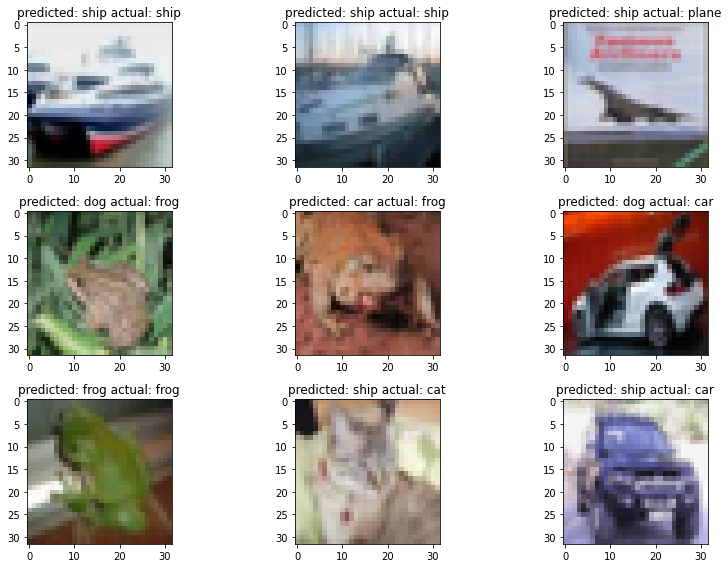

In [249]:
# print images
show_images(test_images, test_labels, predicted_labels, 3, 3, random_sample=False)

#### Accuracy of 25% is pretty bad.. things to try:
1. Manually change some hyper parameters of the CNN: batch_size, learning rate, epochs, # of hidden layers
2. Try other CNN architectures
3. Run HP optimization

In [273]:
num_epochs = 10
learning_rate = 0.001
momentum = 0.9
batch_size = 10
criterion = nn.CrossEntropyLoss()
model = ConvNet()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [274]:
# parameters
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [275]:
trained_model = train_model(trainloader, model, num_epochs, save_model=True)

[epoch 1 / 10, step:1000/5000 loss: 2.299668312072754
[epoch 1 / 10, step:2000/5000 loss: 1.9814563989639282
[epoch 1 / 10, step:3000/5000 loss: 1.450753927230835
[epoch 1 / 10, step:4000/5000 loss: 1.3873164653778076
[epoch 1 / 10, step:5000/5000 loss: 1.5883921384811401
[epoch 2 / 10, step:1000/5000 loss: 1.8616273403167725
[epoch 2 / 10, step:2000/5000 loss: 0.853022575378418
[epoch 2 / 10, step:3000/5000 loss: 1.1407949924468994
[epoch 2 / 10, step:4000/5000 loss: 1.5180237293243408
[epoch 2 / 10, step:5000/5000 loss: 1.6526000499725342
[epoch 3 / 10, step:1000/5000 loss: 1.3050363063812256
[epoch 3 / 10, step:2000/5000 loss: 1.1769418716430664
[epoch 3 / 10, step:3000/5000 loss: 1.3584661483764648
[epoch 3 / 10, step:4000/5000 loss: 0.754516065120697
[epoch 3 / 10, step:5000/5000 loss: 1.379352331161499
[epoch 4 / 10, step:1000/5000 loss: 1.4846833944320679
[epoch 4 / 10, step:2000/5000 loss: 1.5070949792861938
[epoch 4 / 10, step:3000/5000 loss: 1.2961361408233643
[epoch 4 / 10, 

In [276]:
accuracy = test_model(testloader, trained_model, batch_size)

Accuracy of the network: 64.4 %
Accuracy of plane: 75.0 %
Accuracy of car: 72.6 %
Accuracy of bird: 46.0 %
Accuracy of cat: 49.1 %
Accuracy of deer: 55.1 %
Accuracy of dog: 52.1 %
Accuracy of frog: 76.6 %
Accuracy of horse: 65.8 %
Accuracy of ship: 75.0 %
Accuracy of truck: 76.7 %


In [277]:
dataiter = iter(testloader)
test_images, test_labels = dataiter.next()

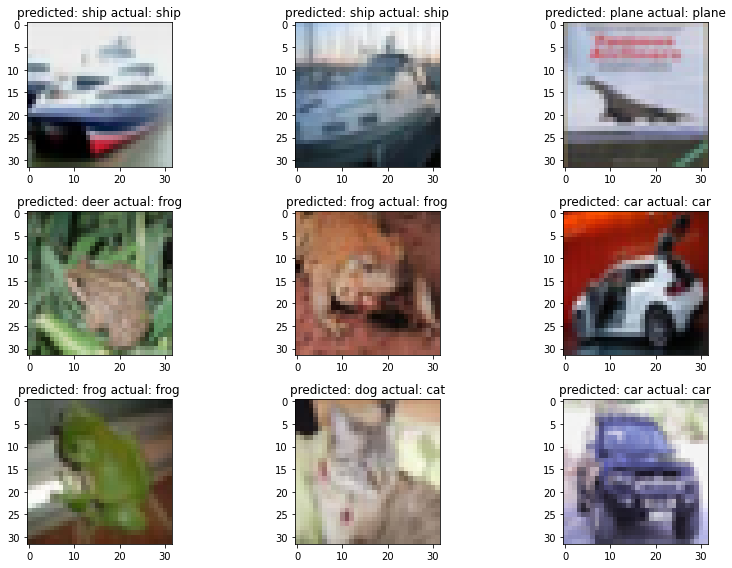

In [278]:
energies = trained_model(test_images)
_, predicted_labels = torch.max(energies, 1)
show_images(test_images, test_labels, predicted_labels, 3, 3, random_sample=False)

#### Found improvement by increasing epochs and batch size. This can be further optimized through hyper parameter optimization. Next we'll try other CNN structures